# Tiny ImageNet

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
from PIL import Image
import torchvision.transforms.functional as TF,torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
set_seed(1103, False)
logging.disable(logging.WARNING)

## Data Processing

In [ ]:
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)
data_path = data_dir / "tiny-imagenet-200.zip"
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

In [ ]:
if not data_path.exists():
    fc.urlsave(url, data_path)
    shutil.unpack_archive(data_path, data_dir)

In [ ]:
dataset_path = data_dir / "tiny-imagenet-200"
train_path = dataset_path / "train"
val_path = dataset_path / "val" / "images"
val_annot_path = dataset_path / "val" / "val_annotations.txt"
wnids_path = dataset_path / "wnids.txt"
words_path = dataset_path / "words.txt"

In [ ]:
xmean = tensor([0.4802, 0.4481, 0.3975]).reshape(-1, 1, 1)
xstd = tensor([0.2723, 0.2658, 0.2751]).reshape(-1, 1, 1)
bs = 256

In [ ]:
train_transform_prenorm = nn.Sequential(
    transforms.RandomCrop(size=64, padding=6),
    transforms.RandomHorizontalFlip(),
    transforms.TrivialAugmentWide()
)

In [ ]:
class TinyDS:
    def __init__(self, path, is_valid=False):
        self.filepaths = list(map(str, path.glob("**/*.JPEG")))
        self.is_valid = is_valid

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, i):
        image = read_image(self.filepaths[i], mode=ImageReadMode.RGB)
        if not self.is_valid:
            image = train_transform_prenorm(image)
        return (image.to(dtype=torch.float32)  / 255. - xmean) / xstd

In [ ]:
class TfmDS:
    def __init__(self, ds, x_tfms=fc.noop, y_tfms=fc.noop):
        fc.store_attr()

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x = self.ds[i]
        return self.x_tfms(x), self.y_tfms(x)

In [ ]:
def tfmx(x, is_valid=False):
    x = TF.resize(x, (32, 32), antialias=True)
    if not is_valid:
        x = rand_erase(x[None], pct=0.1, max_num=5)[0]
    return x

In [ ]:
def denorm(x):
    return (x * xstd + xmean).clip(0, 1)

In [ ]:
train_ds = TfmDS(TinyDS(train_path), tfmx)

torch.Size([3, 32, 32]) torch.Size([3, 64, 64])


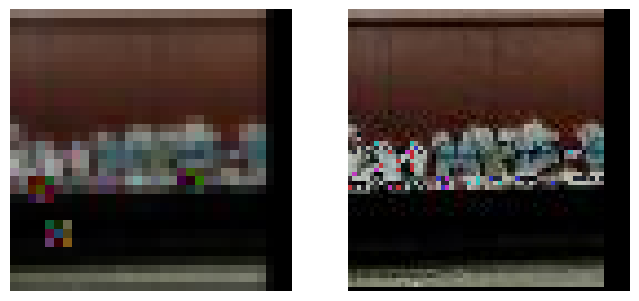

In [ ]:
set_seed(1103, False)
x, y = train_ds[1]
print(x.shape, y.shape)

show_images([denorm(x), denorm(y)], imsize=4);

In [ ]:
train_ds = TfmDS(TinyDS(train_path), tfmx)
val_ds = TfmDS(TinyDS(val_path, is_valid=True), partial(tfmx, is_valid=True))

torch.Size([3, 32, 32]) torch.Size([3, 64, 64])


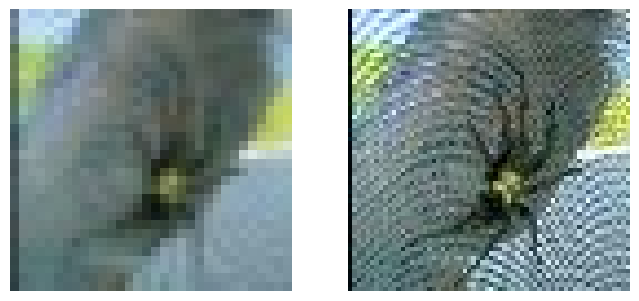

In [ ]:
set_seed(1103, False)
x, y = val_ds[1]
print(x.shape, y.shape)

show_images([denorm(x), denorm(y)], imsize=4);

In [ ]:
bs = 256
dls = DataLoaders(
    DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4),
    DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)
)

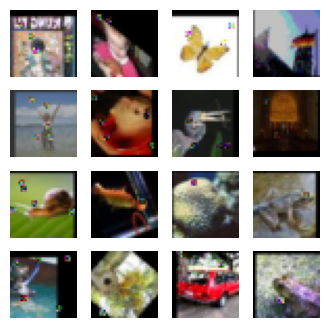

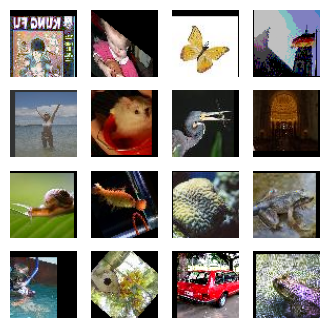

In [ ]:
xb, yb = next(iter(dls.train))
show_images(denorm(xb[:16]), imsize=1);
show_images(denorm(yb[:16]), imsize=1);

## Denoising Autoencoder

In [ ]:
init_w = partial(init_weights, leak=0.1)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB()]
opt_func = partial(optim.AdamW, eps=1e-4)

In [ ]:
def up_block(ni, nf, ks, act, norm):
    return nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor=2),
        ResBlock(ni, nf, ks=ks, act=act, norm=norm)
    )

In [ ]:
up_block(3, 16, 3, act_gr, nn.BatchNorm2d)(torch.randn(1, 3, 4, 4)).shape

torch.Size([1, 16, 8, 8])

In [ ]:
def get_model(act=act_gr, nfs=[32,64,128,256,512,1024], norm=nn.BatchNorm2d, p_drop=0.1):
    model = nn.Sequential(
        ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(p_drop),
        *[ResBlock(nfs[i], nfs[i+1], ks=3, act=act, stride=2, norm=norm) for i in range(len(nfs)-1)],
        nn.Dropout(p_drop),
        *[up_block(nfs[i + 1], nfs[i], ks=3, act=act, norm=norm) for i in reversed(range(len(nfs) - 1))],
        up_block(nfs[0], 3, ks=3, act=act, norm=norm),
        ResBlock(3, 3, ks=3, stride=1, act=nn.Identity, norm=norm)
    )
    return model

In [ ]:
xb.shape, yb.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256, 3, 64, 64]))

In [ ]:
get_model()(xb[:4]).shape

torch.Size([4, 3, 64, 64])

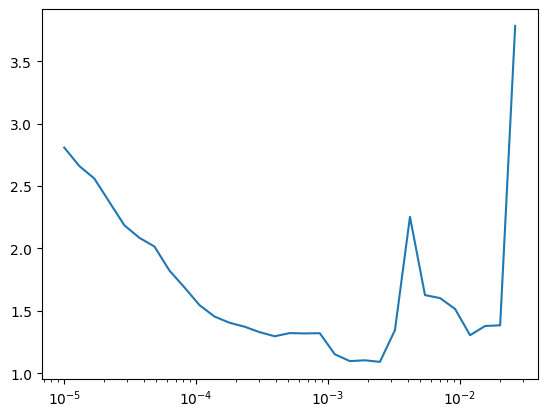

In [ ]:
set_seed(1103, False)
TrainLearner(get_model().apply(init_w), dls, F.mse_loss, lr=0.1, cbs=[DeviceCB()], opt_func=opt_func).lr_find()

In [ ]:
epochs = 5
lr = 0.002
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))


set_seed(1103, False)
model = get_model()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs+[sched], opt_func=opt_func)

In [ ]:
learn.summary()

TOTAL: params=29731034, ~MFLOPs=259.2


|Module|Input|Output|Num params|~MFLOPS|
|-|-|-|-|-|
|ResBlock|[256, 3, 32, 32]|[256, 32, 32, 32]|28320|28.8|
|Dropout2d|[256, 32, 32, 32]|[256, 32, 32, 32]|0|0.0|
|ResBlock|[256, 32, 32, 32]|[256, 64, 16, 16]|57792|14.7|
|ResBlock|[256, 64, 16, 16]|[256, 128, 8, 8]|230272|14.7|
|ResBlock|[256, 128, 8, 8]|[256, 256, 4, 4]|919296|14.7|
|ResBlock|[256, 256, 4, 4]|[256, 512, 2, 2]|3673600|14.7|
|ResBlock|[256, 512, 2, 2]|[256, 1024, 1, 1]|14687232|14.7|
|Dropout|[256, 1024, 1, 1]|[256, 1024, 1, 1]|0|0.0|
|Sequential|[256, 1024, 1, 1]|[256, 512, 2, 2]|7605760|30.4|
|Sequential|[256, 512, 2, 2]|[256, 256, 4, 4]|1902336|30.4|
|Sequential|[256, 256, 4, 4]|[256, 128, 8, 8]|476032|30.4|
|Sequential|[256, 128, 8, 8]|[256, 64, 16, 16]|119232|30.4|
|Sequential|[256, 64, 16, 16]|[256, 32, 32, 32]|29920|30.4|
|Sequential|[256, 32, 32, 32]|[256, 3, 64, 64]|1062|4.3|
|ResBlock|[256, 3, 64, 64]|[256, 3, 64, 64]|180|0.7|


loss,epoch,train
0.704,0,train
0.495,0,valid
0.390,1,train
0.343,1,valid
0.329,2,train
0.314,2,valid
0.301,3,train
0.290,3,valid
0.291,4,train
0.286,4,valid


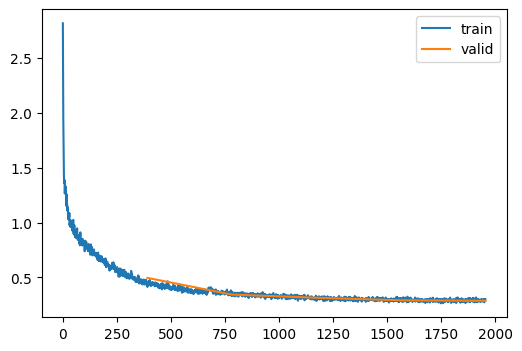

In [ ]:
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "25_superres_autoencoder_5.pkl")

In [ ]:
del learn
del model
clean_mem()

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "25_superres_autoencoder_5.pkl").cpu()

In [ ]:
xb, yb = next(iter(dls.valid))

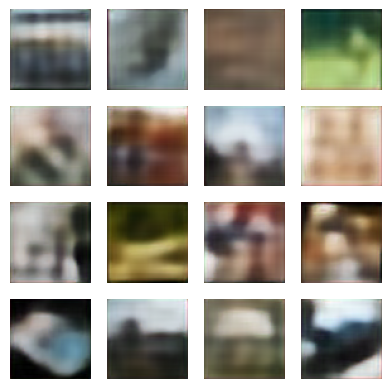

In [ ]:
show_images(denorm(model(xb[:16])), imsize=1.2);

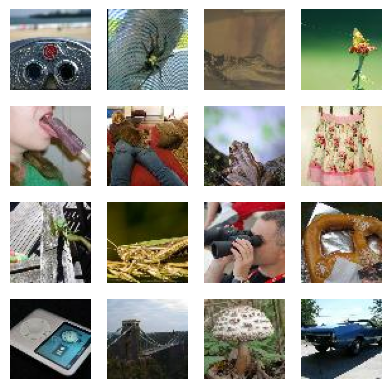

In [ ]:
show_images(denorm(yb[:16]), imsize=1.2);

In [ ]:
del model
clean_mem()

## U-Net

In [ ]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=[32,64,128,256,512,1024], norm=nn.BatchNorm2d, p_drop=0.1):
        super().__init__()
        self.predown = ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)
        self.down = nn.Sequential(
            *[ResBlock(nfs[i], nfs[i+1], ks=3, act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
        )
        self.up = nn.Sequential(
            *[up_block(nfs[i + 1], nfs[i], ks=3, act=act, norm=norm) for i in reversed(range(len(nfs) - 1))],
            up_block(nfs[0], 3, ks=3, act=act, norm=norm)
        )
        self.postup = ResBlock(3, 3, ks=3, stride=1, act=nn.Identity, norm=norm)

    def forward(self, x):
        down_acts = [x]
        x = self.predown(x)
        for l in self.down:
            down_acts.append(x)
            x = l(x)
        for idx, l in enumerate(self.up):
            if idx != 0:
                x += down_acts[-idx]
            x = l(x)
        x = self.postup(x)
        return x

In [ ]:
TinyUnet()(torch.randn((4,3,32,32))).shape

torch.Size([4, 3, 64, 64])

In [ ]:
def zero_wgts(l):
    with torch.no_grad():
        l.weight.zero_()
        l.bias.zero_()

In [ ]:
def init_weights(unet):
    for l in (
        unet.up[-1][-1].id_conv[-1],
        unet.up[-1][-1].convs[-1][-1],
        unet.postup.convs[-1][-1]
    ):
        zero_wgts(l)
    return unet

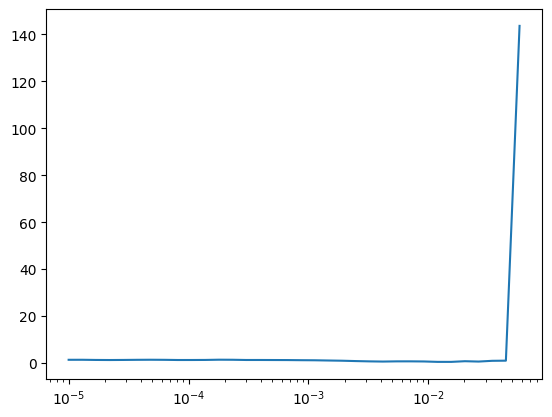

In [ ]:
set_seed(1103, False)
TrainLearner(init_weights(TinyUnet()), dls, F.mse_loss, lr=0.1, cbs=[DeviceCB()], opt_func=opt_func).lr_find()

In [ ]:
epochs = 20
lr = 0.02
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))


set_seed(1103, False)
model = init_weights(TinyUnet())
learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs+[sched], opt_func=opt_func)

In [ ]:
# learn.summary()

loss,epoch,train
0.232,0,train
0.104,0,valid
0.111,1,train
0.086,1,valid
0.092,2,train
0.082,2,valid
0.088,3,train
0.088,3,valid
0.085,4,train
0.081,4,valid


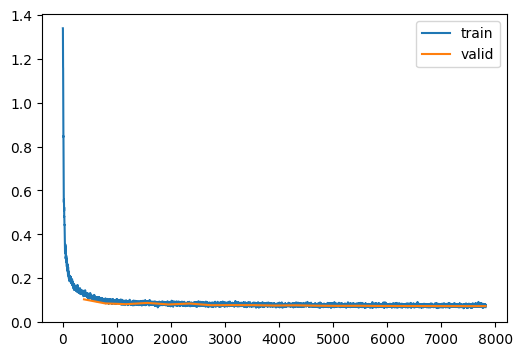

In [ ]:
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "25_superres_unet_20.pkl")

In [ ]:
del learn
del model
clean_mem()

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "25_superres_unet_20.pkl").cpu() #TODO: rerun thses

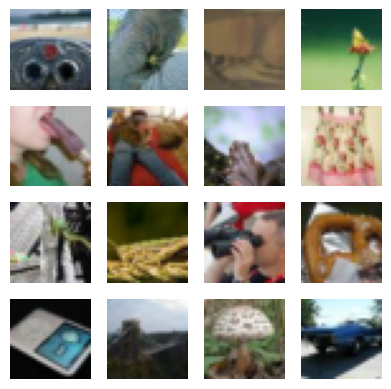

In [ ]:
show_images(denorm(xb[:16]), imsize=1.2);

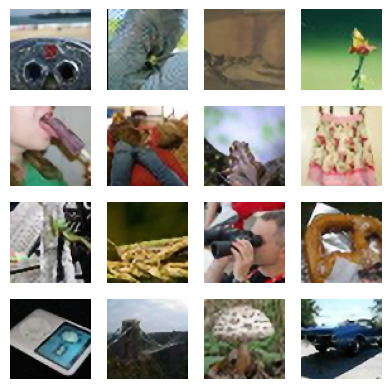

In [ ]:
show_images(denorm(model(xb[:16])), imsize=1.2);

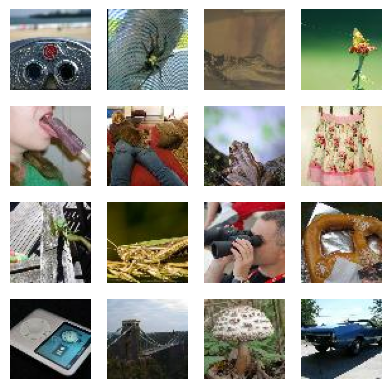

In [ ]:
show_images(denorm(yb[:16]), imsize=1.2);

In [ ]:
del model
clean_mem()

## Perceptual Loss

In [ ]:
bs = 64
dls = DataLoaders(
    DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4),
    DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)
)

In [ ]:
model_path = Path("models")
class_model = torch.load(model_path / "24_imgnet_tiny_deep_wide_aug2_25.pkl").cuda()
# for param in class_model.parameters():
#     param.requires_grad = False

In [ ]:
class_model = class_model[:4]

In [ ]:
def comb_loss(inp, tgt, percep_weight=1.):
    with torch.no_grad():
        tgt_feats = class_model(tgt)
    inp_feats = class_model(inp)
    loss_feats = F.mse_loss(inp_feats, tgt_feats)

    loss_mse = F.mse_loss(inp, tgt)

    return loss_mse + percep_weight * loss_feats

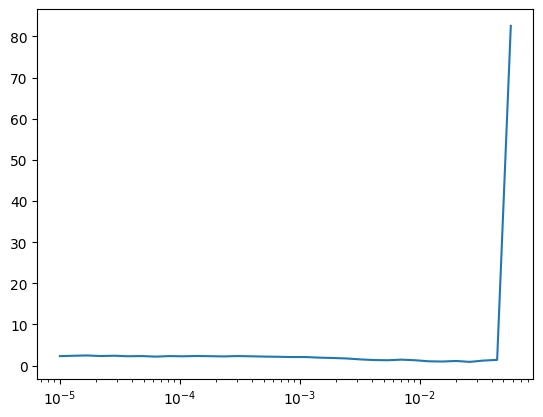

In [ ]:
set_seed(1103, False)
TrainLearner(init_weights(TinyUnet()), dls, comb_loss, lr=0.1, cbs=[DeviceCB()], opt_func=opt_func).lr_find()

In [ ]:
set_seed(1103, False)
model = init_weights(TinyUnet())

In [ ]:
xb, yb = next(iter(dls.valid))

In [ ]:
with torch.no_grad():
    predicted = model(xb)

In [ ]:
with torch.no_grad():
    print(comb_loss(predicted.cuda(), yb.cuda(), percep_weight=0.).item())
    print(comb_loss(predicted.cuda(), yb.cuda(), percep_weight=1.).item())

1.2515225410461426
2.0266685485839844


In [ ]:
epochs = 10  # 20
lr = 0.02
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))


learn = TrainLearner(model, dls, comb_loss, lr=lr, cbs=cbs+[sched], opt_func=opt_func)

loss,epoch,train
0.446,0,train
0.330,0,valid
0.311,1,train
0.316,1,valid
0.302,2,train
0.307,2,valid
0.295,3,train
0.315,3,valid
0.289,4,train
0.299,4,valid


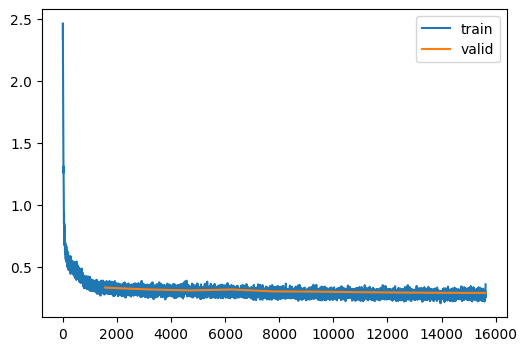

In [ ]:
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "25_superres_unet_percep_20.pkl")

In [ ]:
del learn
del model
clean_mem()

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "25_superres_unet_percep_20.pkl").cpu()

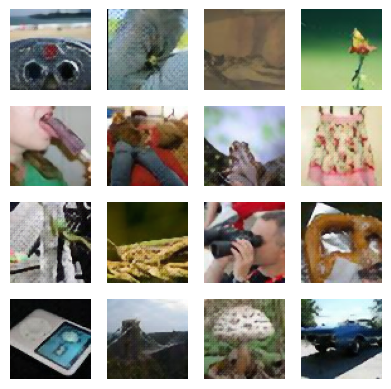

In [ ]:
show_images(denorm(model(xb[:16])), imsize=1.2);

In [ ]:
del model
clean_mem()

## Perceptual Loss (fine tuning)

In [ ]:
model_path = Path("models")
class_model = torch.load(model_path / "24_imgnet_tiny_deep_wide_aug2_25.pkl").cuda()

In [ ]:
def res_blocks(n_bk, ni, nf, stride, ks, act, norm):
    return nn.Sequential(*[
        ResBlock(ni if i == 0 else nf, nf, stride if n_bk - 1 == i else (ks - 1) // 2, ks, act, norm) for i in range(n_bk)
    ])

In [ ]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=[32,64,128,256,512,1024], nbks=[3,3,2,2,1], norm=nn.BatchNorm2d, p_drop=0.1):
        super().__init__()
        self.predown = nn.Sequential(
            ResBlock(3, 8, ks=5, stride=1, act=act, norm=norm),
            ResBlock(8, nfs[0], ks=3, stride=1, act=act, norm=norm)
        )
        self.down = nn.Sequential(
            # *[res_blocks(nbks[i], nfs[i], nfs[i+1], ks=3, act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
            *[ResBlock(nfs[i], nfs[i+1], ks=3, act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
        )
        self.up = nn.Sequential(
            *[up_block(nfs[i + 1], nfs[i], ks=3, act=act, norm=norm) for i in reversed(range(len(nfs) - 1))],
            up_block(nfs[0], 3, ks=3, act=act, norm=norm)
        )
        self.postup = ResBlock(3, 3, ks=3, stride=1, act=nn.Identity, norm=norm)

    def forward(self, x):
        down_acts = [x]
        x = self.predown(x)
        for l in self.down:
            down_acts.append(x)
            x = l(x)
        for idx, l in enumerate(self.up):
            if idx != 0:
                x += down_acts[-idx]
            x = l(x)
        x = self.postup(x)
        return x

In [ ]:
set_seed(1103, False)
model = init_weights(TinyUnet())

In [ ]:
model.predown[0].load_state_dict(class_model[0].state_dict())
model.predown[1].load_state_dict(class_model[1].state_dict())
# for i in range(3, 8):
#     model.down[i - 3].load_state_dict(class_model[i].state_dict())
for i in range(3, 8):
    model.down[i - 3].load_state_dict(class_model[i][0].state_dict())

for p in model.predown.parameters():
    p.requires_grad_(False)
for p in model.down.parameters():
    p.requires_grad_(False)

In [ ]:
class_model = class_model[:4]

loss,epoch,train
0.583,0,train
0.383,0,valid


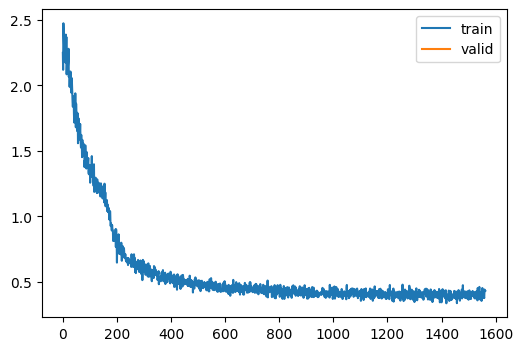

In [ ]:
epochs = 1
lr = 0.002
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

learn = TrainLearner(model, dls, comb_loss, lr=lr, cbs=cbs+[sched], opt_func=opt_func)
learn.fit(epochs)

In [ ]:
for p in model.predown.parameters():
    p.requires_grad_(True)
for p in model.down.parameters():
    p.requires_grad_(True)

loss,epoch,train
0.357,0,train
0.333,0,valid
0.310,1,train
0.309,1,valid
0.294,2,train
0.302,2,valid
0.284,3,train
0.294,3,valid
0.279,4,train
0.291,4,valid


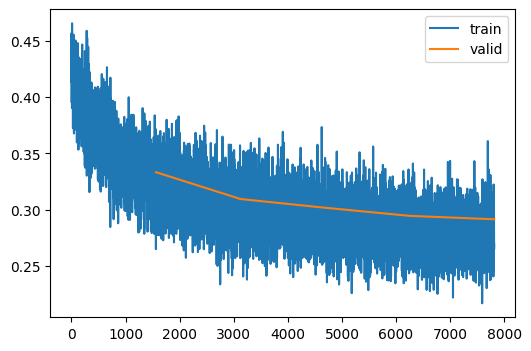

In [ ]:
epochs = 5
lr = 0.02
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

learn = TrainLearner(model, dls, comb_loss, lr=lr, cbs=cbs+[sched], opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "25_superres_unet_percep_finetune_20.pkl")

In [ ]:
del learn
del model
clean_mem()

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "25_superres_unet_percep_finetune_20.pkl").cpu()

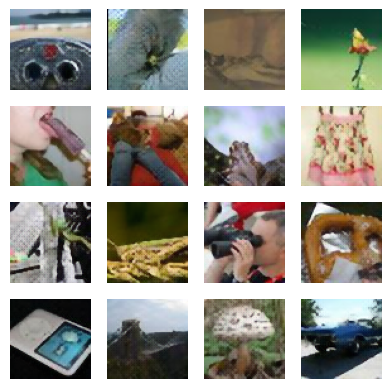

In [ ]:
show_images(denorm(model(xb[:16])), imsize=1.2);

In [ ]:
del model
clean_mem()

## Cross-convs

In [ ]:
model_path = Path("models")
class_model = torch.load(model_path / "24_imgnet_tiny_deep_wide_aug2_25.pkl").cuda()

In [ ]:
xb, yb = next(iter(dls.valid))

In [ ]:
def cross_conv(nf, act=act_gr, norm=nn.BatchNorm2d):
    return nn.Sequential(
        ResBlock(nf, nf, ks=3, stride=1, act=act, norm=norm),
        nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1) 
    )

In [ ]:
xb[:2].shape, cross_conv(3)(xb[:2]).shape

(torch.Size([2, 3, 32, 32]), torch.Size([2, 3, 32, 32]))

In [ ]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=[32,64,128,256,512,1024], nbks=[3,3,2,2,1], norm=nn.BatchNorm2d, p_drop=0.1):
        super().__init__()
        self.predown = nn.Sequential(
            ResBlock(3, 8, ks=5, stride=1, act=act, norm=norm),
            ResBlock(8, nfs[0], ks=3, stride=1, act=act, norm=norm)
        )
        self.down = nn.Sequential(
            # *[res_blocks(nbks[i], nfs[i], nfs[i+1], ks=3, act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
            *[ResBlock(nfs[i], nfs[i+1], ks=3, act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
        )
        self.cross = nn.Sequential(
            *[cross_conv(nfs[i], act=act, norm=norm) for i in range(len(nfs) - 1)]
        )
        self.up = nn.Sequential(
            *[up_block(nfs[i + 1], nfs[i], ks=3, act=act, norm=norm) for i in reversed(range(len(nfs) - 1))],
            up_block(nfs[0], 3, ks=3, act=act, norm=norm)
        )
        self.postup = ResBlock(3, 3, ks=3, stride=1, act=nn.Identity, norm=norm)

    def forward(self, x):
        down_acts = [x]
        x = self.predown(x)
        for l in self.down:
            down_acts.append(x)
            x = l(x)
        for idx, l in enumerate(self.up):
            if idx != 0:
                x += self.cross[-idx](down_acts[-idx])
            x = l(x)
        x = self.postup(x)
        return x

In [ ]:
xb[:2].shape, TinyUnet()(xb[:2]).shape

(torch.Size([2, 3, 32, 32]), torch.Size([2, 3, 64, 64]))

In [ ]:
set_seed(1103, False)
model = init_weights(TinyUnet())

In [ ]:
model.predown[0].load_state_dict(class_model[0].state_dict())
model.predown[1].load_state_dict(class_model[1].state_dict())
# for i in range(3, 8):
#     model.down[i - 3].load_state_dict(class_model[i].state_dict())
for i in range(3, 8):
    model.down[i - 3].load_state_dict(class_model[i][0].state_dict())

for p in model.predown.parameters():
    p.requires_grad_(False)
for p in model.down.parameters():
    p.requires_grad_(False)

In [ ]:
class_model = class_model[:4]

loss,epoch,train
0.518,0,train
0.346,0,valid


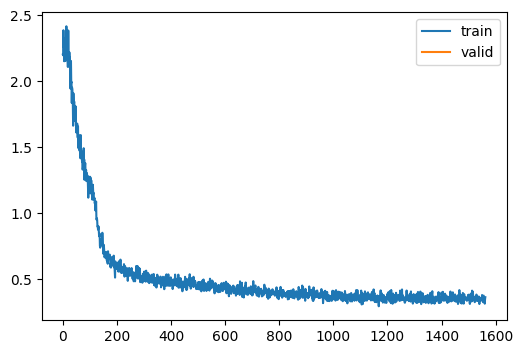

In [ ]:
epochs = 1
lr = 0.002
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

learn = TrainLearner(model, dls, comb_loss, lr=lr, cbs=cbs+[sched], opt_func=opt_func)
learn.fit(epochs)

In [ ]:
for p in model.predown.parameters():
    p.requires_grad_(True)
for p in model.down.parameters():
    p.requires_grad_(True)

loss,epoch,train
0.332,0,train
0.326,0,valid
0.302,1,train
0.307,1,valid
0.289,2,train
0.304,2,valid
0.283,3,train
0.295,3,valid
0.278,4,train
0.293,4,valid


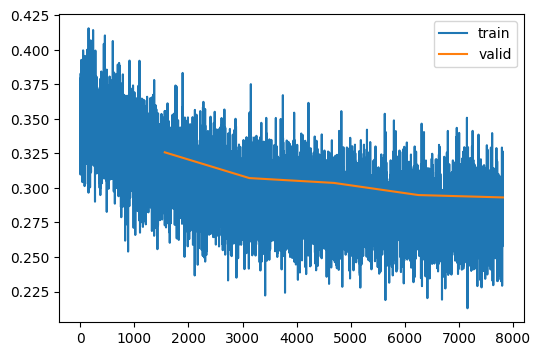

In [ ]:
epochs = 5
lr = 0.007
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

learn = TrainLearner(model, dls, comb_loss, lr=lr, cbs=cbs+[sched], opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "25_superres_unet_cross_percep_finetune_20.pkl")

In [ ]:
del learn
del model
clean_mem()

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "25_superres_unet_cross_percep_finetune_20.pkl").cpu()

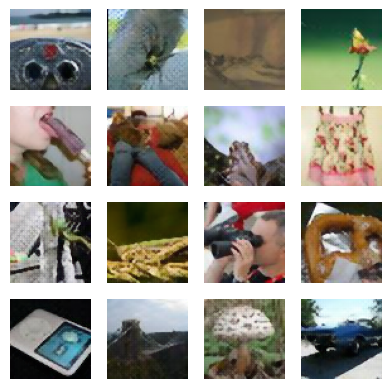

In [ ]:
show_images(denorm(model(xb[:16])), imsize=1.2);

In [ ]:
del model
clean_mem()